In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

/home/omar/.local/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super().__init__()

        # Define the downsampling layers (contracting path)
        self.downs = nn.ModuleList()

        # Define the upsampling layers (expanding path)
        self.ups_transpose = nn.ModuleList()  # List for ConvTranspose2d layers
        self.ups_conv = nn.ModuleList()       # List for DoubleConv blocks

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down path of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up path of U-Net (upsampling)
        for feature in reversed(features):
            self.ups_transpose.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups_conv.append(DoubleConv(feature*2, feature))

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final 1x1 convolution to get the output channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def down(self, x, skip_connections):
        """
        This method performs the downsampling (contracting) part of the U-Net.
        It appends the feature map to skip_connections and pools the output.
        """
        for down in self.downs:
            x = down(x)  # Apply DoubleConv block
            skip_connections.append(x)
            x = self.pool(x)  # Apply max-pooling for downsampling
        return x

    def up(self, x, skip_connections):
        """
        This method performs the upsampling (expanding) part of the U-Net.
        It applies ConvTranspose2d followed by DoubleConv at each step.
        """
        skip_connections = skip_connections[::-1]  # Reverse the skip connections list
        for idx in range(len(self.ups_transpose)):  # Loop through the transpose layers
            x = self.ups_transpose[idx](x)  # Apply ConvTranspose2d to upsample
            skip_connection = skip_connections[idx]  # Get the corresponding skip connection

            # Resize the upsampled output to match the skip connection shape
            #(this will occur if the image pixels aren't divided by 2)
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate the skip connection with the upsampled feature map
            concat_skip = torch.cat((skip_connection, x), dim=1)

            # Apply DoubleConv block to refine the concatenated feature map
            x = self.ups_conv[idx](concat_skip)

        return x

    def forward(self, x):
        skip_connections = []
        x = self.down(x, skip_connections)
        x = self.bottleneck(x)
        x = self.up(x, skip_connections)
        return self.final_conv(x)

In [3]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Step 3: Set dataset paths using current working directory
current_dir = os.getcwd()  # Get current working directory (useful for Jupyter Notebooks)
train_images_dir = os.path.join(current_dir, "train")
train_masks_dir = os.path.join(current_dir, "train_masks")
verification_images_dir = os.path.join(current_dir, "validation")
verification_masks_dir = os.path.join(current_dir, "validation_masks")


In [4]:
def get_loaders(
    train_images_dir,
    train_masks_dir,
    verification_images_dir,
    verification_masks_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    # Create train dataset
    train_ds = CarvanaDataset(
        image_dir=train_images_dir,       # Use the updated variable for train images
        mask_dir=train_masks_dir,         # Use the updated variable for train masks
        transform=train_transform,
    )

    # Create train DataLoader
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    # Create validation dataset
    val_ds = CarvanaDataset(
        image_dir=verification_images_dir,   # Use the updated variable for validation images
        mask_dir=verification_masks_dir,     # Use the updated variable for validation masks
        transform=val_transform,
    )

    # Create validation DataLoader
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [5]:
device = torch.device('cuda')
epsilon = 0.2  # Max perturbation strength
num_epochs_uap = 7  # UAP training epochs
batch_size = 4
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True

# Define the transformation for training
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

# Define the transformation for validation
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


In [6]:
train_loader, val_loader = get_loaders(
    train_images_dir,          # Path to training images
    train_masks_dir,           # Path to training masks
    verification_images_dir,   # Path to validation images
    verification_masks_dir,    # Path to validation masks
    batch_size,
    train_transform,           # Training transformations
    val_transforms,            # Validation transformations
    NUM_WORKERS,
    PIN_MEMORY,
)

In [7]:
# Load Pretrained Model
model = torch.load(
    'unet_complete_model.pth',
    map_location=device,
    weights_only=False  # Required if model contains custom classes
).to(device)
model.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [8]:
delta = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH), requires_grad=True, device=device)
optimizer = torch.optim.SGD([delta], lr=0.1, momentum=0.9)  # Reduced lr for stability
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs_uap):
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).unsqueeze(1).float()
        
        # Forward
        perturbed_images = torch.clamp(images + delta, 0, 1)
        outputs = model(perturbed_images)
        loss = -criterion(outputs, masks)  # Maximize loss
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Update delta
        optimizer.step()
        with torch.no_grad():
            delta.data = torch.clamp(delta, -epsilon, epsilon)  # Clamp AFTER update
        
        epoch_loss += loss.item()
    
    print(f'UAP Epoch [{epoch+1}/{num_epochs_uap}] Loss: {epoch_loss/len(train_loader):.4f}')

UAP Epoch [1/7] Loss: -0.5531
UAP Epoch [2/7] Loss: -3.8787
UAP Epoch [3/7] Loss: -4.0856
UAP Epoch [4/7] Loss: -4.1559
UAP Epoch [5/7] Loss: -4.1940
UAP Epoch [6/7] Loss: -4.2193
UAP Epoch [7/7] Loss: -4.2371


In [9]:
torch.save({
    'delta': delta.detach().cpu(),
    'epsilon': epsilon,
    'input_shape': (3, IMAGE_HEIGHT, IMAGE_WIDTH)
}, 'uap_perturbation.pth')


In [10]:
def evaluate(loader, delta=None):
    dice_scores = []
    model.eval()
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            
            if delta is not None:
                images = torch.clamp(images + delta, 0, 1)
            
            outputs = model(images)
            
            # Apply sigmoid and threshold
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            # Reshape masks to match preds: (B, H, W) -> (B, 1, H, W)
            masks = masks.unsqueeze(1)
            
            dice = dice_score(preds, masks)
            dice_scores.append(dice.item())
    
    model.train()
    return sum(dice_scores) / len(dice_scores)

def dice_score(pred, target):
    smooth = 1e-5
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [11]:
# Evaluate on Validation Set
clean_dice = evaluate(val_loader)
perturbed_dice = evaluate(val_loader, delta)

print(f'\nResults:')
print(f'Clean Dice Score: {clean_dice:.4f}')
print(f'Perturbed Dice Score: {perturbed_dice:.4f}')
print(f'Performance Drop: {clean_dice - perturbed_dice:.4f}')



Results:
Clean Dice Score: 0.9837
Perturbed Dice Score: 0.3263
Performance Drop: 0.6574


In [12]:
def plot_results(image, perturbed, clean_pred, perturbed_pred, mask):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    # Detach tensors and remove gradients
    image = image.detach().cpu()
    perturbed = perturbed.detach().cpu()
    clean_pred = clean_pred.detach().cpu()
    perturbed_pred = perturbed_pred.detach().cpu()
    mask = mask.detach().cpu()
    
    # Remove batch dimension if present
    if image.dim() == 4:  # [B, C, H, W]
        image = image.squeeze(0)
    if perturbed.dim() == 4:
        perturbed = perturbed.squeeze(0)
    
    # Plot images
    ax[0,0].imshow(image.permute(1, 2, 0).numpy())
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(perturbed.permute(1, 2, 0).numpy())
    ax[0,1].set_title('Perturbed Image')

    # Calculate and normalize perturbation
    perturbation = perturbed - image
    perturbation_normalized = torch.clamp((perturbation + epsilon) / (2 * epsilon), 0, 1)
    
    # Plot perturbation with diverging colormap
    ax[0,2].imshow(
        perturbation_normalized.permute(1, 2, 0).numpy(),
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    ax[0,2].set_title('Perturbation (Normalized)')
    # Plot predictions and mask
    ax[1,0].imshow(clean_pred.squeeze().numpy(), cmap='gray')
    ax[1,0].set_title('Clean Prediction')
    ax[1,1].imshow(perturbed_pred.squeeze().numpy(), cmap='gray')
    ax[1,1].set_title('Perturbed Prediction')
    ax[1,2].imshow(mask.squeeze().numpy(), cmap='gray')
    ax[1,2].set_title('Ground Truth')
    
    plt.show()


In [13]:
sample_batch = next(iter(val_loader))

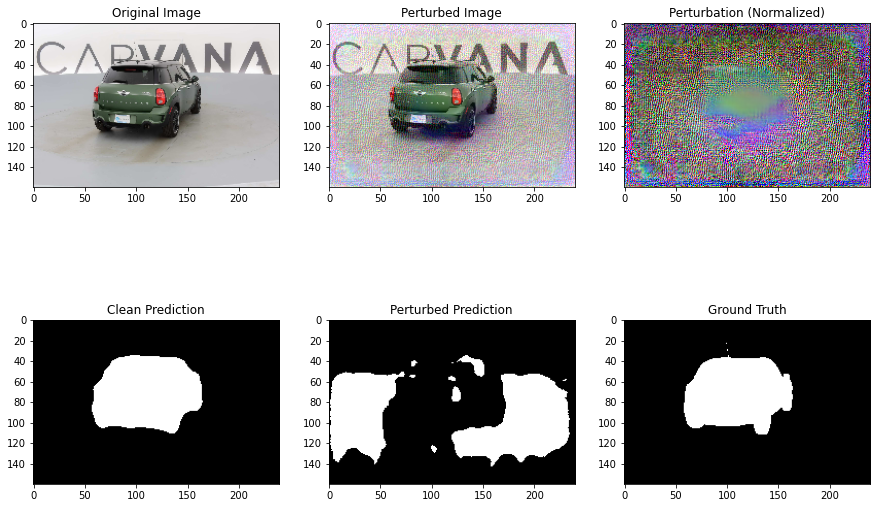

In [14]:
sample_images, sample_masks = sample_batch
sample_images = sample_images.to(device)
sample_masks = sample_masks.to(device)

# Generate predictions
with torch.no_grad():
    clean_preds = torch.sigmoid(model(sample_images))
    perturbed_preds = torch.sigmoid(model(torch.clamp(sample_images + delta, 0, 1)))

# Plot first sample
plot_results(
    sample_images[0],
    (sample_images[0] + delta).clamp(0, 1),  # Don't squeeze here
    (clean_preds[0] >= 0.5).float(),
    (perturbed_preds[0] >= 0.5).float(),
    sample_masks[0].to(device)
)

In [15]:
def save_plot(image, perturbed, clean_pred, perturbed_pred, mask, filename):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    # Detach tensors and remove gradients
    image = image.detach().cpu()
    perturbed = perturbed.detach().cpu()
    clean_pred = clean_pred.detach().cpu()
    perturbed_pred = perturbed_pred.detach().cpu()
    mask = mask.detach().cpu()
    
    # Remove batch dimension if present
    if image.dim() == 4:  # [B, C, H, W]
        image = image.squeeze(0)
    if perturbed.dim() == 4:
        perturbed = perturbed.squeeze(0)
    
    # Plot images
    ax[0,0].imshow(image.permute(1, 2, 0).numpy())
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(perturbed.permute(1, 2, 0).numpy())
    ax[0,1].set_title('Perturbed Image')

    # Calculate and normalize perturbation
    perturbation = perturbed - image
    perturbation_normalized = torch.clamp((perturbation + epsilon) / (2 * epsilon), 0, 1)
    
    # Plot perturbation with diverging colormap
    ax[0,2].imshow(
        perturbation_normalized.permute(1, 2, 0).numpy(),
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    ax[0,2].set_title('Perturbation (Normalized)')
    # Plot predictions and mask
    ax[1,0].imshow(clean_pred.squeeze().numpy(), cmap='gray')
    ax[1,0].set_title('Clean Prediction')
    ax[1,1].imshow(perturbed_pred.squeeze().numpy(), cmap='gray')
    ax[1,1].set_title('Perturbed Prediction')
    ax[1,2].imshow(mask.squeeze().numpy(), cmap='gray')
    ax[1,2].set_title('Ground Truth')
    
    plt.savefig(filename)
    plt.close(fig) 


In [16]:
output_dir = "UAP_attack_images"
os.makedirs(output_dir, exist_ok=True)

# Number of batches and samples per batch to save
num_batches = 5
samples_per_batch = 4

# Loop through validation batches
for batch_idx, (sample_images, sample_masks) in enumerate(val_loader):
    if batch_idx >= num_batches:
        break
    
    # Move data to device
    sample_images = sample_images.to(device)
    sample_masks = sample_masks.to(device)
    
    # Generate predictions
    with torch.no_grad():
        clean_preds = torch.sigmoid(model(sample_images))
        perturbed_images = torch.clamp(sample_images + delta, 0, 1)
        perturbed_preds = torch.sigmoid(model(perturbed_images))
    
    # Save plots for each sample in the batch
    for sample_idx in range(samples_per_batch):
        if sample_idx >= sample_images.size(0):  # Handle smaller final batch
            break
            
        save_plot(
            image=sample_images[sample_idx],
            perturbed=perturbed_images[sample_idx],
            clean_pred=(clean_preds[sample_idx] > 0.5).float(),
            perturbed_pred=(perturbed_preds[sample_idx] > 0.5).float(),
            mask=sample_masks[sample_idx],
            filename=os.path.join(output_dir, 
                                f"batch_{batch_idx:02d}_sample_{sample_idx:02d}.png")
        )
        
    print(f"Processed batch {batch_idx+1}/{num_batches}")

print(f"All plots saved to {output_dir} directory")

Processed batch 1/5
Processed batch 2/5
Processed batch 3/5
Processed batch 4/5
Processed batch 5/5
All plots saved to UAP_attack_images directory
